In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load data

In [2]:
html_file_path = 'data/raw/2021-06-02.html'
data = pd.read_html(html_file_path)

# Review data

In [3]:
type(data)

list

In [4]:
len(data)

11

In [5]:
type(data[0])

pandas.core.frame.DataFrame

In [6]:
next_matches_index = 0
standings_indexes = range(1,7)
goalkeepers_index = 7
defenders_index = 8
midfielders_index = 9
forwards_index = 10

In [7]:
data[next_matches_index]

,תאריך,שעה,קבוצה מארחת,תוצאה,קבוצה אורחת,סקירה
0,11.06.2021,22:00,טורקיה,---,איטליה,לסקירה
1,12.06.2021,16:00,וויילס,---,שווייץ,לסקירה
2,12.06.2021,19:00,דנמרק,---,פינלנד,לסקירה
3,12.06.2021,22:00,בלגיה,---,רוסיה,לסקירה
4,13.06.2021,16:00,אנגליה,---,קרואטיה,לסקירה
5,13.06.2021,19:00,אוסטריה,---,צפון מקדוניה,לסקירה
6,13.06.2021,22:00,הולנד,---,אוקראינה,לסקירה
7,14.06.2021,16:00,סקוטלנד,---,צ`כיה,לסקירה
8,14.06.2021,19:00,פולין,---,סלובקיה,לסקירה
9,14.06.2021,22:00,ספרד,---,שבדיה,לסקירה


In [8]:
data[random.randint(min(standings_indexes), max(standings_indexes))]

,#,קבוצה,מש’,נצ’,תיקו,הפסד,יחס,נקודות
0,1,רוסיה,0,0,0,0,0-0,0
1,2,בלגיה,0,0,0,0,0-0,0
2,3,פינלנד,0,0,0,0,0-0,0
3,4,דנמרק,0,0,0,0,0-0,0


In [9]:
data[random.randint(goalkeepers_index, forwards_index)]

,קישור,מחיר,נק’,Unnamed: 3
0,אנטואן גרייזמן (צרפת),13.0m,0,NaN
1,ג'יידון סאנצ'ו (אנגליה),13.0m,0,NaN
2,קווין דה בריינה (בלגיה),13.0m,0,NaN
3,אדן הזאר (בלגיה),12.0m,0,NaN
4,לירוי סאנה (גרמניה),12.0m,0,NaN
...,...,...,...,...
251,סטפן ספירובסקי (צפון מקדוניה),3.0m,0,NaN
252,פטר שבצ'יק (צ`כיה),3.0m,0,NaN
253,פרהאן חסאני (צפון מקדוניה),3.0m,0,NaN
254,רובין קולוויל (וויילס),3.0m,0,NaN


# Data reorganize and pre-process

In [10]:
next_matches_columns_renames = {"תאריך": "date", "שעה": "hour", "קבוצה מארחת": "home_team", "תוצאה": "score", "קבוצה אורחת": "away_team", "סקירה": "review"}
next_matches_df = data[next_matches_index].rename(columns=next_matches_columns_renames)
del next_matches_df['hour']
del next_matches_df['review']
next_matches_df['date'] = pd.to_datetime(next_matches_df['date'], format="%d.%m.%Y")

In [11]:
next_matches_df

,date,home_team,score,away_team
0,2021-06-11,טורקיה,---,איטליה
1,2021-06-12,וויילס,---,שווייץ
2,2021-06-12,דנמרק,---,פינלנד
3,2021-06-12,בלגיה,---,רוסיה
4,2021-06-13,אנגליה,---,קרואטיה
5,2021-06-13,אוסטריה,---,צפון מקדוניה
6,2021-06-13,הולנד,---,אוקראינה
7,2021-06-14,סקוטלנד,---,צ`כיה
8,2021-06-14,פולין,---,סלובקיה
9,2021-06-14,ספרד,---,שבדיה


In [12]:
standings_columns_renames = {"קבוצה": "team", "מש’": "MP", "נצ’": "W", "תיקו": "D", "הפסד": "L", "יחס": "GF-GA", "נקודות": "Pts"}
groups_standings = []
for index in standings_indexes:
    new_standing_df = data[index].rename(columns=standings_columns_renames)
    new_standing_df['GF'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[0]).astype('int')
    new_standing_df['GA'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[1]).astype('int')
    new_standing_df['GD'] = new_standing_df['GF'] - new_standing_df['GA']
    del new_standing_df['GF-GA']
    groups_standings.append(new_standing_df)

In [13]:
groups_standings[random.randint(0, len(groups_standings)-1)]

,#,team,MP,W,D,L,Pts,GF,GA,GD
0,1,הולנד,0,0,0,0,0,0,0,0
1,2,אוקראינה,0,0,0,0,0,0,0,0
2,3,צפון מקדוניה,0,0,0,0,0,0,0,0
3,4,אוסטריה,0,0,0,0,0,0,0,0


In [14]:
gaolkeepers_columns_renames = {"שוער": "name", "מחיר": "price", "נק’": "points"}
gaolkeepers_df = data[goalkeepers_index].rename(columns=gaolkeepers_columns_renames)
gaolkeepers_df['position'] = 'GK'
del gaolkeepers_df['Unnamed: 3']

defenders_columns_renames = {"הגנה": "name", "מחיר": "price", "נק’": "points"}
defenders_df = data[defenders_index].rename(columns=defenders_columns_renames)
del defenders_df['Unnamed: 3']
defenders_df['position'] = 'D'

midfielders_columns_renames = {"קישור": "name", "מחיר": "price", "נק’": "points"}
midfielders_df = data[midfielders_index].rename(columns=midfielders_columns_renames)
del midfielders_df['Unnamed: 3']
midfielders_df['position'] = 'M'

forwards_columns_renames = {"התקפה": "name", "מחיר": "price", "נק’": "points"}
forwards_df = data[forwards_index].rename(columns=forwards_columns_renames)
del forwards_df['Unnamed: 3']
forwards_df['position'] = 'FW'

In [15]:
players_df = pd.concat([gaolkeepers_df, defenders_df, midfielders_df, forwards_df], ignore_index=True)
players_df['team'] = players_df['name'].apply(lambda x: ((x.split('('))[1].split(")"))[0])
players_df['name'] = players_df['name'].apply(lambda x: ((x.split('('))[0])[:-1])
players_df['price'] = players_df['price'].apply(lambda x: (x.split('.'))[0]).astype('int')

In [16]:
players_df

,name,price,points,position,team
0,הוגו לוריס,10,0,GK,צרפת
1,אונאי סימון,9,0,GK,ספרד
2,טיבו קורטואה,9,0,GK,בלגיה
3,מנואל נוייר,9,0,GK,גרמניה
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה
...,...,...,...,...,...
613,מילאן ריסטובסקי,4,0,FW,צפון מקדוניה
614,מרקוס פורס,4,0,FW,פינלנד
615,ריאן כריסטי,4,0,FW,סקוטלנד
616,ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה


# Generate random* lineup
*with constraints on formation, budget, maximum players allowed from the same team, minimal player price.

In [17]:
def get_random_lineup(players_df, formation=[4,3,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=4):
    
    if sum(formation) != 10:
        print("Error: Illegal formation. Formation must sum up to 10 players.")
        return
    if (formation[0] < 3 or formation[0] > 5) or (formation[1] < 3 or formation[1] > 5)  or (formation[2] < 1 or formation[2] > 3): 
        print("Error: Illegal formation. 3 <= Defenders,Midfielders <= 5, 1 <= Forwards <= 3")
        return
    
    players_df = players_df[players_df['price'] >= min_player_price]
    
    used_budegt = 0
    same_team = 0
    while (used_budegt < budget - budget_delta) or (same_team > max_same_team):
        lineup_df = pd.concat([players_df[players_df['position'] == 'GK'].sample(),
                               players_df[players_df['position'] == 'D'].sample(formation[0]),
                               players_df[players_df['position'] == 'M'].sample(formation[1]),
                               players_df[players_df['position'] == 'FW'].sample(formation[2])])
        used_budegt = lineup_df['price'].sum()
        same_team = lineup_df['team'].value_counts().max()
    
    print(f'Used budget: {used_budegt}.0M')
    return lineup_df

In [18]:
# lineup_df = get_random_lineup(players_df)
# lineup_df

In [19]:
lineup_df = get_random_lineup(players_df, formation=[3,4,3], budget=100, budget_delta=2, max_same_team=2, min_player_price=5)
lineup_df

Used budget: 100.0M


,name,price,points,position,team
3,מנואל נוייר,9,0,GK,גרמניה
86,אמריק לאפורט,8,0,D,ספרד
77,ג'ורדי אלבה,9,0,D,ספרד
157,יאניק וסטרגארד,6,0,D,דנמרק
370,ג'וד בלינגהאם,6,0,M,אנגליה
277,ג'יידון סאנצ'ו,13,0,M,אנגליה
347,כריסטוף באומגרטנר,7,0,M,אוסטריה
364,אליף אלמאס,6,0,M,צפון מקדוניה
544,דריס מרטנס,11,0,FW,בלגיה
534,קיליאן אמבפה,15,0,FW,צרפת


# Features engineering

## Teams features
1. Average betting odds
2. Average power rankings (pr) - source: The Guardian, FIFA, Reddit and my own.
3. Form (points lost in last 6 matches)
4. Wighted sum (of all features)

In [20]:
teams_file_path = 'data/teams.csv'
teams_df = pd.read_csv(teams_file_path, encoding='utf-8')
teams_df

,name_h,name_e,theguardian_pr,fifa_ranking,reddit1_pr,reddit2_pr,my_pr,bets_odds,form_last6
0,צרפת,France,1,2,1,1,2,4.68,WWWDWW
1,אנגליה,England,4,3,8,9,1,5.03,WWWWWL
2,בלגיה,Belgium,3,1,2,6,5,6.20,WDWWWW
3,ספרד,Spain,10,5,5,3,7,7.87,WWDWDD
4,גרמניה,Germany,2,8,9,4,3,7.93,DLWWLW
5,פורטוגל,Portugal,6,4,3,2,10,8.59,WDWWLW
6,איטליה,Italy,7,6,4,5,4,10.37,WWWWWW
7,הולנד,Netherlands,16,11,6,7,6,12.26,DWWLWW
8,דנמרק,Denmark,8,7,7,10,8,27.05,DWWWLW
9,קרואטיה,Croatia,18,10,13,8,11,34.27,DWWLLL


### Normalize features
* MimMax normalize (to [0,1])

In [21]:
power_rank_columns = ["theguardian_pr", "fifa_ranking", "reddit1_pr", "reddit2_pr", "my_pr"]
teams_df['power_rank_avg'] = teams_df[power_rank_columns].mean(axis=1)
max_points = 18
teams_df['form_points_lost'] = max_points - ( 3 * teams_df['form_last6'].str.count('W') +  teams_df['form_last6'].str.count('D'))

teams_df.drop(power_rank_columns, axis='columns', inplace=True)
teams_df.drop('form_last6', axis='columns', inplace=True)
teams_df

,name_h,name_e,bets_odds,power_rank_avg,form_points_lost
0,צרפת,France,4.68,1.4,2
1,אנגליה,England,5.03,5.0,3
2,בלגיה,Belgium,6.20,3.4,2
3,ספרד,Spain,7.87,6.0,6
4,גרמניה,Germany,7.93,5.2,8
5,פורטוגל,Portugal,8.59,5.0,5
6,איטליה,Italy,10.37,5.2,0
7,הולנד,Netherlands,12.26,9.2,5
8,דנמרק,Denmark,27.05,8.0,5
9,קרואטיה,Croatia,34.27,12.0,11


In [22]:
minimum = teams_df['bets_odds'].min()
maximum = teams_df['bets_odds'].max()
teams_df['bets_odds'] = (teams_df['bets_odds'] - minimum)/(maximum - minimum)

minimum = teams_df['power_rank_avg'].min()
maximum = teams_df['power_rank_avg'].max()
teams_df['power_rank_avg'] = (teams_df['power_rank_avg'] - minimum)/(maximum - minimum)

minimum = teams_df['form_points_lost'].min()
maximum = teams_df['form_points_lost'].max()
teams_df['form_points_lost'] = (teams_df['form_points_lost'] - minimum)/(maximum - minimum)

teams_df

,name_h,name_e,bets_odds,power_rank_avg,form_points_lost
0,צרפת,France,0.000000,0.000000,0.153846
1,אנגליה,England,0.000716,0.162162,0.230769
2,בלגיה,Belgium,0.003110,0.090090,0.153846
3,ספרד,Spain,0.006528,0.207207,0.461538
4,גרמניה,Germany,0.006650,0.171171,0.615385
5,פורטוגל,Portugal,0.008001,0.162162,0.384615
6,איטליה,Italy,0.011643,0.171171,0.000000
7,הולנד,Netherlands,0.015511,0.351351,0.384615
8,דנמרק,Denmark,0.045775,0.297297,0.384615
9,קרואטיה,Croatia,0.060550,0.477477,0.846154


In [23]:
teams_df.describe()

,bets_odds,power_rank_avg,form_points_lost
count,24.000000,24.000000,24.000000
mean,0.241872,0.500000,0.538462
std,0.306170,0.300420,0.290489
min,0.000000,0.000000,0.000000
25%,0.010733,0.198198,0.365385
50%,0.147568,0.504505,0.500000
75%,0.278229,0.725225,0.788462
max,1.000000,1.000000,1.000000


### Make features "higher is better" and calculate wighted sum feature

In [24]:
teams_df['bets_odds'] = 1 - teams_df['bets_odds']
teams_df['power_rank_avg'] = 1 - teams_df['power_rank_avg']
teams_df['form_points_lost'] = 1 - teams_df['form_points_lost']

In [25]:
w_bets_odds = 0.5
w_power_rank_avg = 0.3
w_form_points_lost = 0.2
w_power = 1.4
teams_df['wighted_sum'] = (w_bets_odds * teams_df['bets_odds']) + (w_power_rank_avg * teams_df['power_rank_avg']) + (w_form_points_lost * teams_df['form_points_lost'])
teams_df['wighted_sum'] = np.power(teams_df['wighted_sum'], w_power)

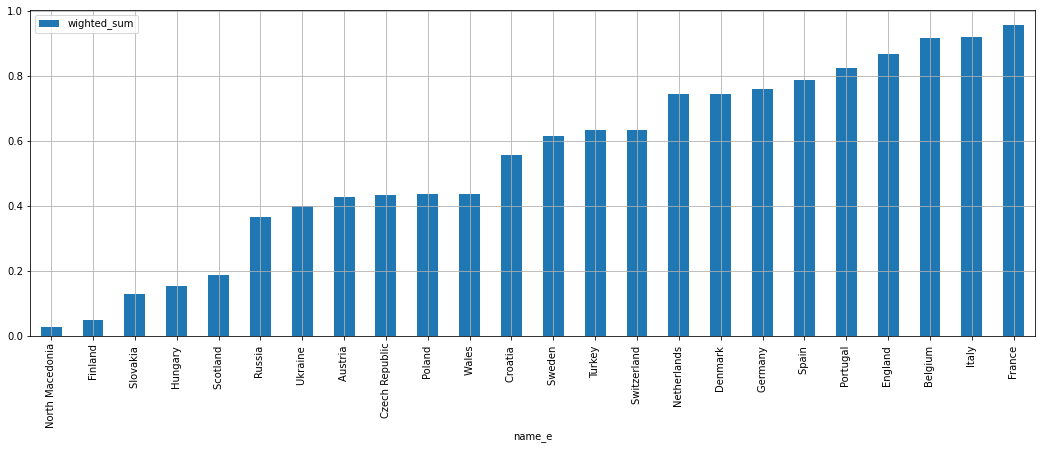

In [26]:
teams_df.sort_values("wighted_sum", inplace=True)
teams_df.plot(x="name_e", y=["wighted_sum"], kind="bar", figsize=(18,6));
plt.grid();
plt.xticks(rotation=90);

## Players features
1. Accumulated points
2. Team power rank
3. Team GF
4. Team GA
5. Team GD
6. Opponent power rank diffenrence
7. Opponent GF
8. Opponent GA
9. Opponent GD

### Get Team power ranking, GF, GA

In [27]:
teams_df = teams_df[['name_h', 'wighted_sum']].set_index('name_h')
players_df['team_pr'] = players_df.apply(lambda row: teams_df.loc[row['team']], axis=1)

In [28]:
total_standings_df = pd.concat(groups_standings)
total_standings_df = total_standings_df[['team', 'GF', 'GA']].set_index('team')
players_df['team_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GF'), axis=1)
players_df['team_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GA'), axis=1)

### Get Opponent power ranking, GF, GA

In [34]:
opponents1_df = next_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = next_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_df = pd.concat([opponents1_df, opponents2_df])
opponents_df['opponent'] = opponents_df.fillna('').sum(axis=1)
opponents_df.drop(columns=['home_team', 'away_team'], inplace=True)
players_df['opponent'] = players_df.apply(lambda row: opponents_df.loc[row['team']], axis=1)

In [36]:
players_df['opponent_pr'] = players_df.apply(lambda row: teams_df.loc[row['opponent']], axis=1)

In [38]:
players_df['opponent_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GF'), axis=1)
players_df['opponent_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GA'), axis=1)

In [39]:
players_df

,name,price,points,position,team,team_pr,team_GF,team_GA,opponent,opponent_pr,opponent_GF,opponent_GA
0,הוגו לוריס,10,0,GK,צרפת,0.957190,0,0,גרמניה,0.760331,0,0
1,אונאי סימון,9,0,GK,ספרד,0.786374,0,0,שבדיה,0.615554,0,0
2,טיבו קורטואה,9,0,GK,בלגיה,0.917906,0,0,רוסיה,0.366186,0,0
3,מנואל נוייר,9,0,GK,גרמניה,0.760331,0,0,צרפת,0.957190,0,0
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,0,0,טורקיה,0.633793,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
613,מילאן ריסטובסקי,4,0,FW,צפון מקדוניה,0.027573,0,0,אוסטריה,0.427429,0,0
614,מרקוס פורס,4,0,FW,פינלנד,0.046977,0,0,דנמרק,0.745812,0,0
615,ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,0,0,צ`כיה,0.432834,0,0
616,ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,0.027573,0,0,אוסטריה,0.427429,0,0
